,provincename,districtname,sectorname,cellname,village,upi,size,land_use_name_kinyarwanda,transaction_type_name,sale_price,start_date,Year
0,Eastern,Bugesera,Gashora,Biryogo,Kivugiza,5/07/01/01/1004,231.0,Gutura,Transfer by Voluntary Sale,450000.0,02/09/2023,NaN
1,Eastern,Bugesera,Gashora,Biryogo,Kanyonyomba,5/07/01/01/1015,341.0,Gutura,Transfer by Voluntary Sale,500000.0,28/03/2023,NaN
2,Eastern,Bugesera,Gashora,Biryogo,Biryogo,5/07/01/01/1039,116.0,Gutura,Transfer by Voluntary Sale,2800000.0,28/04/2023,NaN
3,Eastern,Bugesera,Gashora,Biryogo,Kagarama,5/07/01/01/104,1276.0,Ubuhinzi,Transfer by Voluntary Sale,3000000.0,10/08/2022,NaN
4,Eastern,Bugesera,Gashora,Biryogo,Kagarama,5/07/01/01/106,492.0,Ubuhinzi,Transfer by Voluntary Sale,3550000.0,19/12/2023,NaN


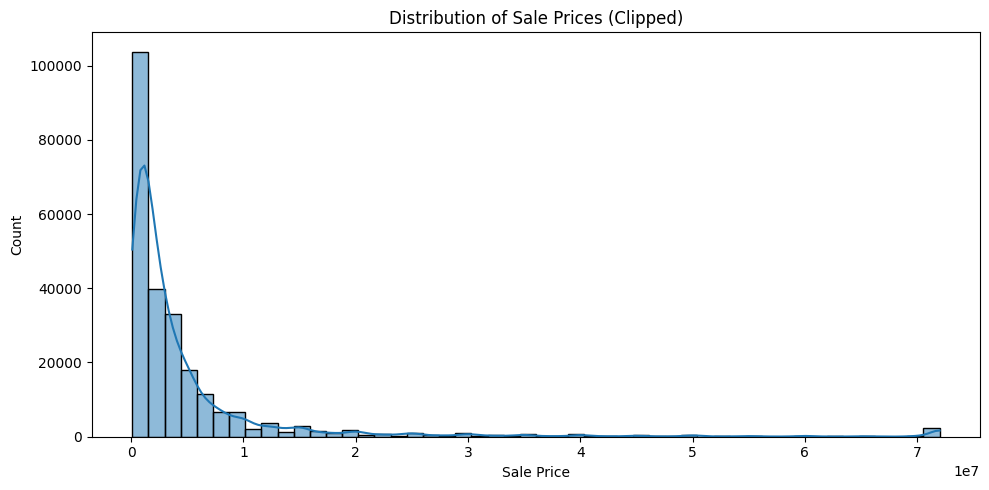

This graph shows the clipped distribution of sale prices for land transactions in Rwanda 2023. Outliers are removed for clarity.


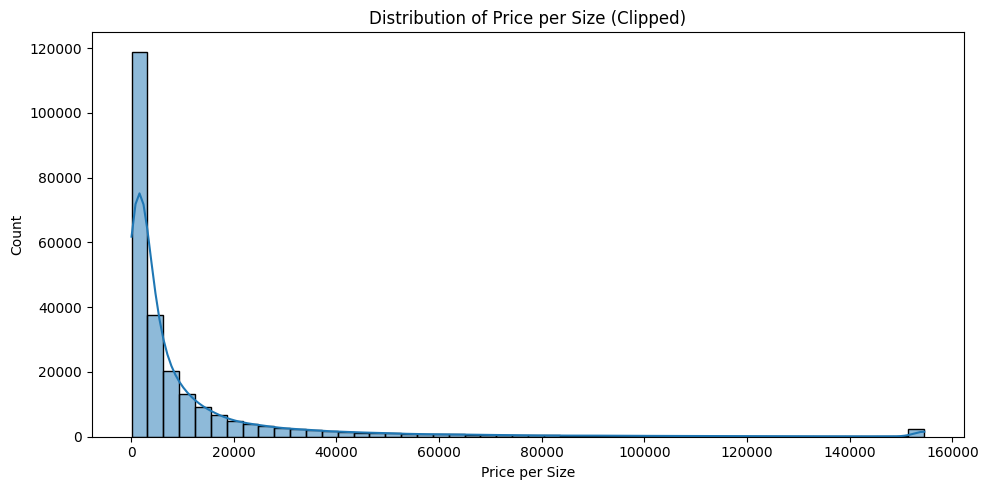

This graph shows the clipped distribution of price per unit size, highlighting land value variation.


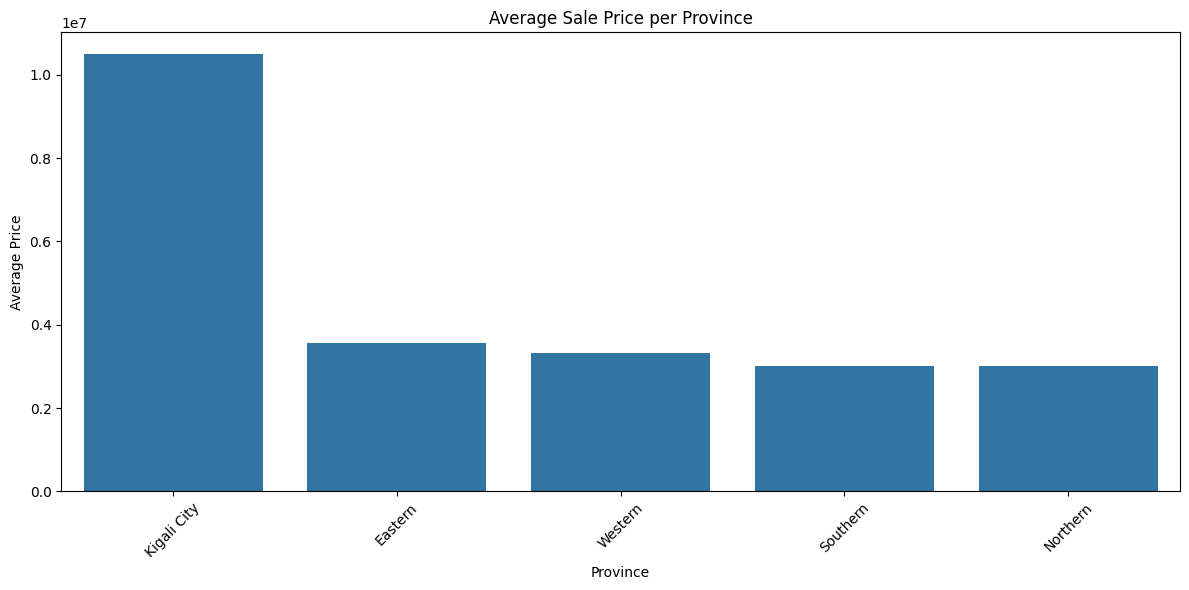

This bar chart compares average sale prices across provinces, revealing regional market differences.


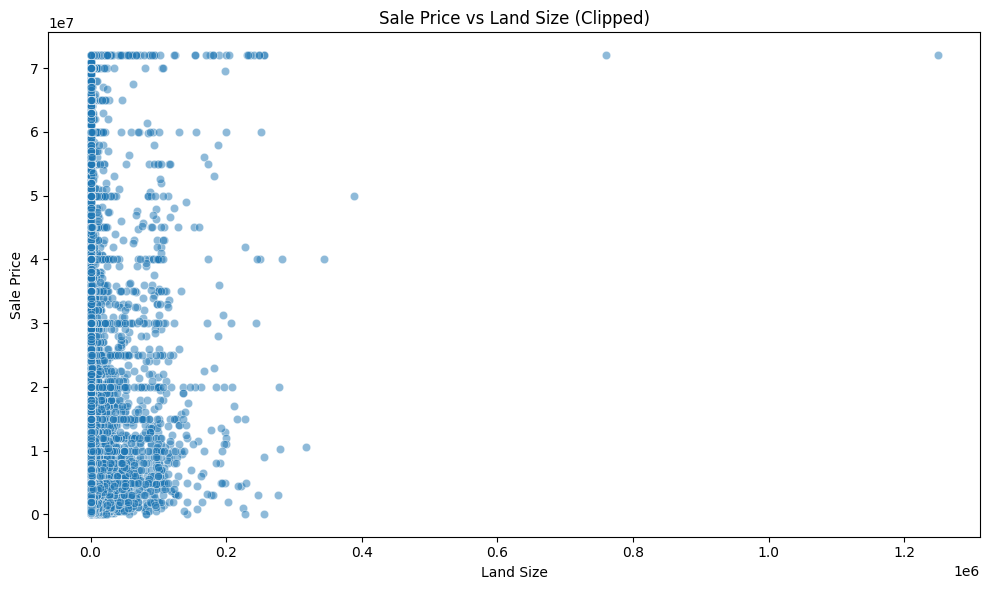

This scatter plot shows the relationship between land size and sale price, with outliers clipped.


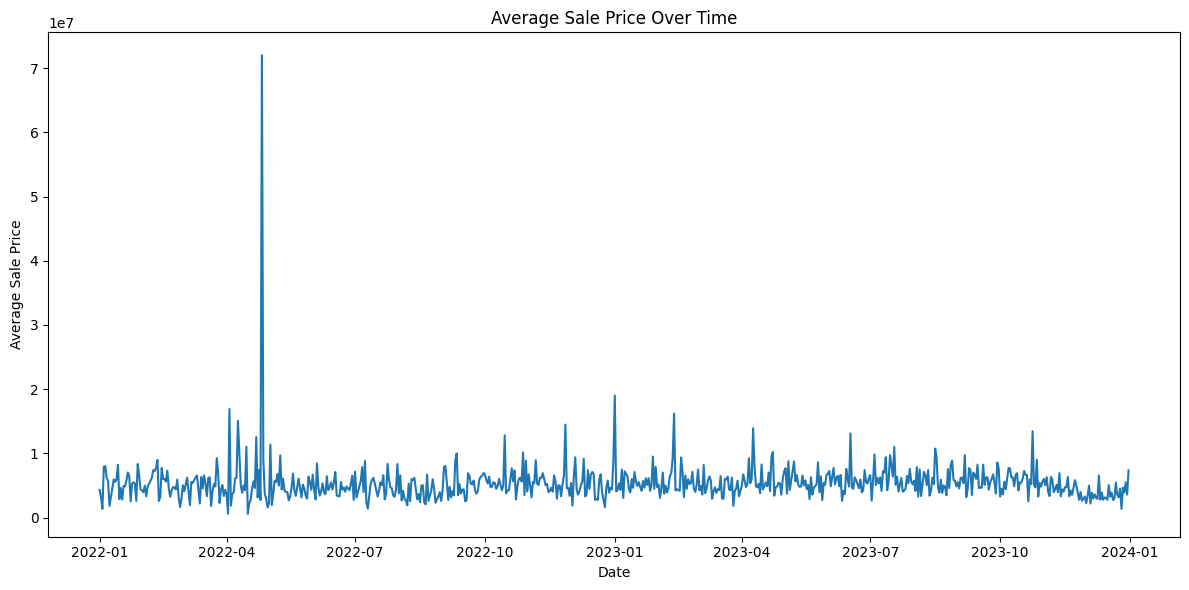

This line chart tracks average sale price trends over time, indicating market direction and seasonality.


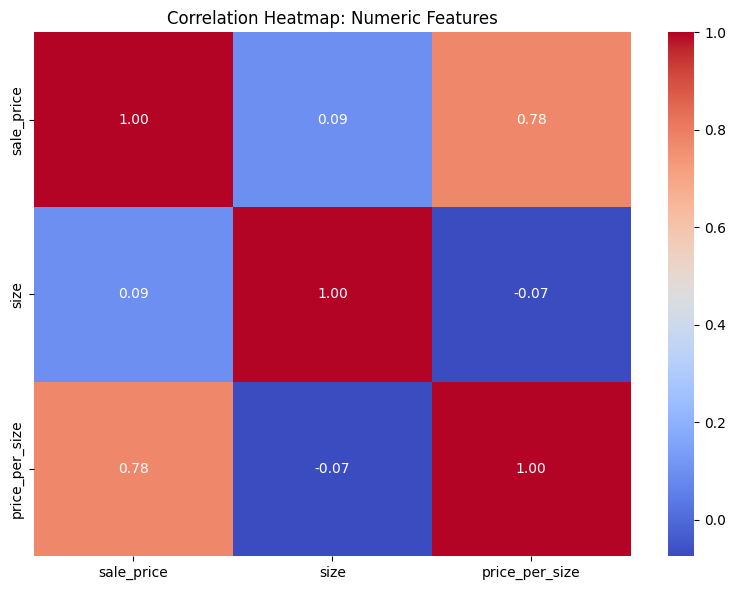

This heatmap visualizes correlations between numeric features, useful for understanding relationships and feature selection.
Model Architecture: Meta Prophet
- Additive time-series model with trend, seasonality, and holiday components.
- Uses automatic changepoint detection.
- Optimization: Stan-based Bayesian fitting.


interactive(children=(Dropdown(description='province', options=('All', 'Western', 'Eastern', 'Southern', 'Nort…

<function __main__.forecast_prices(province='All', district='All', level='Monthly', period=60)>

In [1]:
# ===========================
# Rwanda Real Estate Forecast
# Using Meta Prophet
# ===========================

# ---------------------------
# 1. Imports
# ---------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown

# ---------------------------
# 2. Load Dataset
# ---------------------------
df = pd.read_csv("./dataset/bugesera_sample_market_trends.csv")

# Preview data
display(df.head())

# ---------------------------
# 3. Data Cleaning & Outlier Clipping
# ---------------------------
# Remove 'year' column if mostly empty
if 'year' in df.columns and df['year'].isnull().mean() > 0.5:
    df = df.drop(columns=['year'])

# Convert start_date to datetime
df['start_date'] = pd.to_datetime(df['start_date'], format='%d/%m/%Y', errors='coerce')

# Handle missing values
df = df.dropna(subset=['sale_price', 'start_date', 'provincename', 'districtname'])

# Remove duplicates
if 'upi' in df.columns:
    df = df.sort_values('start_date').drop_duplicates(subset=['upi'], keep='last')

# Remove negative or zero values
df = df[df['sale_price'] > 0]
df = df[df['size'] > 0]

# Price per size
df['price_per_size'] = df['sale_price'] / df['size']

# Clip outliers for sale_price and price_per_size
for col in ['sale_price', 'price_per_size']:
    lo, hi = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lo, hi)

# ---------------------------
# 4. Data Visualization
# ---------------------------
# Sale price distribution
plt.figure(figsize=(10,5))
sns.histplot(df['sale_price'], bins=50, kde=True)
plt.title("Distribution of Sale Prices (Clipped)")
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
print("This graph shows the clipped distribution of sale prices for land transactions in Rwanda 2023. Outliers are removed for clarity.")

# Price per size distribution
plt.figure(figsize=(10,5))
sns.histplot(df['price_per_size'], bins=50, kde=True)
plt.title("Distribution of Price per Size (Clipped)")
plt.xlabel("Price per Size")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
print("This graph shows the clipped distribution of price per unit size, highlighting land value variation.")

# Average price per province
avg_price_province = df.groupby('provincename')['sale_price'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=avg_price_province.index, y=avg_price_province.values)
plt.title("Average Sale Price per Province")
plt.xlabel("Province")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("This bar chart compares average sale prices across provinces, revealing regional market differences.")

# Price vs size scatter
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='size', y='sale_price', alpha=0.5)
plt.title("Sale Price vs Land Size (Clipped)")
plt.xlabel("Land Size")
plt.ylabel("Sale Price")
plt.tight_layout()
plt.show()
print("This scatter plot shows the relationship between land size and sale price, with outliers clipped.")

# Trend over time
df_time = df.groupby('start_date')['sale_price'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=df_time, x='start_date', y='sale_price')
plt.title("Average Sale Price Over Time")
plt.xlabel("Date")
plt.ylabel("Average Sale Price")
plt.tight_layout()
plt.show()
print("This line chart tracks average sale price trends over time, indicating market direction and seasonality.")

# Correlation heatmap (numeric features)
numeric_cols = ['sale_price', 'size', 'price_per_size']
corr = df[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap: Numeric Features")
plt.tight_layout()
plt.show()
print("This heatmap visualizes correlations between numeric features, useful for understanding relationships and feature selection.")

# ---------------------------
# 5. Model Architecture (Prophet)
# ---------------------------
print("Model Architecture: Meta Prophet")
print("- Additive time-series model with trend, seasonality, and holiday components.")
print("- Uses automatic changepoint detection.")
print("- Optimization: Stan-based Bayesian fitting.")

# ---------------------------
# 6. Interactive Filters
# ---------------------------
def filter_data(province, district, level, period):
    data = df.copy()
    if province != "All":
        data = data[data['provincename']==province]
    if district != "All":
        data = data[data['districtname']==district]
    
    # Aggregate data based on user selection
    if level == "Daily":
        agg = data.groupby('start_date')['sale_price'].mean().reset_index()
    elif level == "Monthly":
        agg = data.groupby(data['start_date'].dt.to_period('M'))['sale_price'].mean().reset_index()
        agg['start_date'] = agg['start_date'].dt.to_timestamp()
    elif level == "Yearly":
        agg = data.groupby(data['start_date'].dt.year)['sale_price'].mean().reset_index()
        agg.rename(columns={'start_date':'year'}, inplace=True)
        agg['start_date'] = pd.to_datetime(agg['year'], format='%Y')
    # Limit to selected period for prediction
    if period > 0 and len(agg) > period:
        agg = agg.tail(period)
    return agg

province_options = ["All"] + df['provincename'].unique().tolist()
district_options = ["All"] + df['districtname'].unique().tolist()
level_options = ["Daily", "Monthly", "Yearly"]

# ---------------------------
# 7. Prepare Prophet Data
# ---------------------------
def prepare_prophet_df(filtered_df):
    prophet_df = filtered_df[['start_date','sale_price']].rename(columns={'start_date':'ds','sale_price':'y'})
    return prophet_df

# ---------------------------
# 8. Forecasting with Prophet & Performance Metrics
# ---------------------------
def forecast_prices(province="All", district="All", level="Monthly", period=60):
    # Filter and aggregate
    filtered_df = filter_data(province, district, level, period)
    prophet_df = prepare_prophet_df(filtered_df)

    # Prophet model
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(prophet_df)

    # Forecast for selected period and future years
    last_date = prophet_df['ds'].max()
    future_years = 3
    freq = 'D' if level=="Daily" else 'M' if level=="Monthly" else 'Y'
    future = model.make_future_dataframe(periods=future_years*12 if freq=='M' else future_years, freq=freq)
    forecast = model.predict(future)

    # Plot forecast
    fig1 = model.plot(forecast)
    plt.title(f"Forecasted Sale Prices ({future_years} Years) - {province} / {district}")
    plt.tight_layout()
    plt.show()
    print("This forecast graph shows predicted sale prices for the next 3 years based on selected filters and period.")

    # Component plot
    fig2 = model.plot_components(forecast)
    plt.tight_layout()
    plt.show()
    print("Component plots show trend, seasonality, and holiday effects in the forecast.")

    # Performance metrics (only for overlap with actual)
    merged = pd.merge(prophet_df, forecast[['ds','yhat']], on='ds', how='inner')
    if not merged.empty:
        mae = mean_absolute_error(merged['y'], merged['yhat'])
        # Fix for sklearn version: remove 'squared' argument if not supported
        try:
            rmse = mean_squared_error(merged['y'], merged['yhat'], squared=False)
        except TypeError:
            rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
        r2 = r2_score(merged['y'], merged['yhat'])
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")
    else:
        print("No overlap between actual and forecasted dates for metrics.")

    # Identify best investment locations
    growth = filtered_df.groupby(['provincename','districtname'])['sale_price'].mean().pct_change().sort_values(ascending=False).head(5)
    print("\nTop 5 locations with highest growth (potential investment):")
    print(growth)

# ---------------------------
# 9. Interactive Widget
# ---------------------------
interact(forecast_prices, province=Dropdown(options=province_options, value="All"),
         district=Dropdown(options=district_options, value="All"),
         level=Dropdown(options=level_options, value="Monthly"),
         period=(12,120,1))